# Notebook for analyzing Insider tradings and the effects on stock prices
Written by Thomas Niedermayer and Gunnar Sjúrðarson Knudsen, as a conjoined effort for an interdiscplinary project in Data Science.

Supervisor: Wolfgang Aussenegg

Co-Supervisor: Sascha Hunold

Purpose of this notebook is XXX

## Remaining todos:

* T1_ vs T1!!!
* A lot!
* Clean up library loading - Pycharm it!!
* Figure out which custom functions we are still using
  - * How much would Thomas hate me, if I moved "Main" to a notebook as well?
* Figure out if different hypotheses should be tested based on "NAME" - or do both do all analysis?
* Refactor - we have data locations in two different varialbes (CAPS and preceeding underscore)
* I MIGHT have deleted too much from data_checks.run
* main.py: check which imports are used
* Currently have two different datasets for the ReturnIndex data - with (linear) interpolation, as well as skipping rows that don't exist in market and company.
* Figure out what to do, when event date not in the dataset. Could still "just" do closest possible, provided that trades occur around the date.
* Rerun main.py for Niedermayer - needs the re-processed dataset with market information!
* What do we do when tickers are non-unique!? I think this is a nasty that breaks more than we know
* document get_all_directors_dealings_async
* document analyse_single_company
* Are outliers "Significant"? Wilcoxon compared to t-test

#### Ask Prof. Aussenegg
* How to compare before and after pandemic? subsample to get the same sample size and 2 sample ttest?
* Is it fair to compare like before pandemic with during pandemic? when there is an estimation window in the pre pandemic time and the event window is in the pandemic time
* : T1 19 or 20 BEFORE event? (e.g. 40 or 41 day window)?
* Are we allowed to persist the preprocessed data for this study?

### Hypotheses

#### Gunnar

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in the first
weeks after disclosure.
2. Hypothesis 2: Trades of type “Purchase” are most explaining of abnormal return.
“Sale” less so, and “Sale + Option” does not have an effect.
3. Hypothesis 3: Directors have changed behaviour during the times of Covid.

#### Tom

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in
the first weeks after disclosure of relevant information.
2. Hypothesis 2: Insiders are significantly good at avoiding risk indicated
by market downturns after insiders selling shares.
3. Hypothesis 3: Directors have changed behaviour during the times of
covid: Hypotheses 1 and 2 can be answered with significantly different
confidence before and during the pandemic.



## Setup

### Define which analysis is run
Add a name here. This affects which data is read in, as well as which analysis are done?

In [1]:
NAME = "Knudsen" # "Niedermayer"

### Load Libraries

In [2]:
# Standard libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import time
import datetime
from dateutil.relativedelta import relativedelta
import requests
import locale
from pandas.io.json import json_normalize
import os
from os.path import exists
import sys
import io
from tqdm import tqdm

# custom functions
import source.read_tickers_and_isins as URTI
import source.get_directors_dealings as UGDD
import source.get_timeseries as UGT
import source.analyze_get_summary_of_data as AGSOD
import source.preprocess_directors_dealings as UPDD
import source.preprocess_timeseries as UPTS
import source.preprocess_timeseries_from_excel as UPTFE
import source.analyse_single_company as UASC
import source.calculate_daily_returns_for_period as CDRFP
from source import data_checks, determine_T0_T1_T2, cut_timeseries, calculate_coefficients
import logging

# Custom - stolen from the macro analysis
from source.data_checks import DataSizeException
from source.determine_T0_T1_T2 import TimeSeriesMismatchException

logging.getLogger().setLevel(logging.WARNING)
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'axes.labelsize': 10,
    'font.size': 11,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 96
})


#plt.style.use("seaborn")

### Read in the data

In [3]:
# Data locations
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI_discard/'

## Fairly certain that these are no longer used
#DATA_LOCATION_INSIDER_RAW = DATA_LOCATION + 'raw/insider/'
#DATA_LOCATION_TIME_SERIES_RAW = DATA_LOCATION + 'raw/timeseries/'
#DATA_LOCATION_TIME_SERIES_PROCESSED = DATA_LOCATION + 'processed/timeseries/'

## Not sure why we do this - maybe refactor
_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED

# Get locations to read in
file_locs_ = os.listdir(_ri_location)
file_locs = [_ri_location + f for f in file_locs_]

# Actually read in the company information
companies = []
print("loading return series...")
for file_loc in tqdm(file_locs):
    with open(file_loc, "rb") as f:
        company = pickle.load(f)
    companies.append(company)

loading return series...


100%|██████████| 4077/4077 [00:08<00:00, 463.12it/s]


## Exploratory Data Analysis

### Calculate Returns, Analyse Companies

In [4]:
print("Returns")
returns_df = [c.return_index_df.company_return for c in companies]

print("concatenate")
df_returns = pd.concat(returns_df, axis=1)
df_return_index = pd.concat([c.return_index_df for c in companies], axis=1)

print("analyse ...")
pickles = os.listdir(DATA_LOCATION_RI)

#WTF?! Why does this break??
ISINs = [rick[:-7] for rick in pickles][:100] # TODO remove slice
#ISINs = [rick for rick in pickles]

outputs = []
for isin in tqdm(ISINs):
    outputs.append(UASC.analyse_single_company(isin, DATA_LOCATION_RI, DATA_LOCATION_INSIDER_PROCESSED))


Returns
concatenate
analyse ...


100%|██████████| 100/100 [00:09<00:00, 10.48it/s]


### Visualise Mean Daily Returns

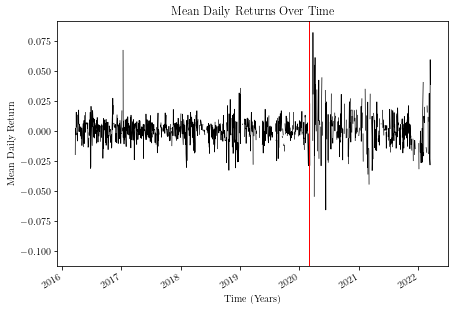

In [5]:
plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)')
ax.set_ylabel('Mean Daily Return')
ax.set_title('Mean Daily Returns Over Time')

interval_borders = ["2020-03-01"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.jpg", dpi=600)
plt.show()


### Investigate Filing Trade Lag Times

Negative lag for 0 out of 7519 trades.
Lag longer than 21 days for 339 out of 7519 trades.
Eligible trades: 7180 out of 7519 trades.


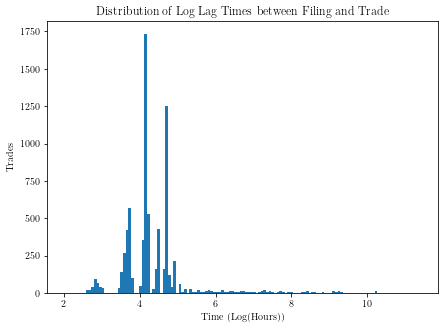

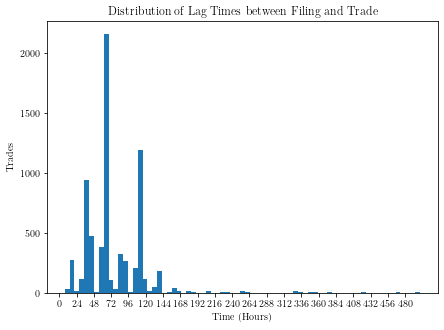

In [6]:
sum_returns = sum([x[0] for x in outputs], [])
filing_trade_lags = sum([x[1] for x in outputs], [])

lag_in_hours = np.asarray(filing_trade_lags)
negative_lag_mask = lag_in_hours < 0
positive_lag = lag_in_hours[~negative_lag_mask]
in_21_days = positive_lag < 21*24
relevant_lag = positive_lag[in_21_days]
print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
print(f"Lag longer than 21 days for {len(positive_lag) - len(relevant_lag)} out of {len(negative_lag_mask)} trades.")
print(f"Eligible trades: {len(relevant_lag)} out of {len(negative_lag_mask)} trades.")

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(np.log(positive_lag), bins="auto")
ax.set_xlabel('Time (Log(Hours))')
ax.set_ylabel('Trades')
ax.set_title('Distribution of Log Lag Times between Filing and Trade')

plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.jpg", dpi=600)
plt.show()

without_outliers = positive_lag[positive_lag < 24*21]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(without_outliers, bins="auto")
plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Trades')
ax.set_title('Distribution of Lag Times between Filing and Trade')

plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.jpg", dpi=600)

## Demonstrate process for a single event

### Define windows

#### Our data contains multiple companies. A single company contains multiple filings and each filing is an event

![alt text](assets/images/windows.png "Title")

In [7]:
## Constants defining how long both Estimation Window and Event Window are
### Probably also input parameters to a function call, as we need loops later...
L1_length = 100
L2_length = 40 # TODO +-20 days = 40 days, right?

### Fix a company

In [8]:
logging.getLogger().setLevel(logging.DEBUG)

if NAME == "Knudsen":
    company_index = -87
elif NAME == "Niedermayer":
    company_index = -11
else:
    raise NotImplementedError
company = companies[company_index]
print(company)
company_return = company.return_index_df
insider_data_df = pd.read_csv(_insider_location + company.ticker + '.csv', index_col=0, parse_dates=['FilingDate', 'TradeDate'])

Company(company_type=938260, isin='US9871841089', name='YORK WATER', ticker='YORW', start_date=Timestamp('1996-08-20 00:00:00'), end_date=Timestamp('2022-03-16 00:00:00'), return_index_df=            ReturnIndex  company_return  market_return
Date                                                  
2016-03-21      1020.66             NaN            NaN
2016-03-22      1023.42        0.002704       0.002660
2016-03-23      1015.49       -0.007749      -0.010951
2016-03-24      1022.04        0.006450       0.000973
2016-03-28      1016.53       -0.005391      -0.001406
...                 ...             ...            ...
2022-03-10      1697.39       -0.011858      -0.009475
2022-03-11      1681.25       -0.009509      -0.021794
2022-03-14      1677.02       -0.002516      -0.020445
2022-03-15      1693.16        0.009624       0.029202
2022-03-16      1688.93       -0.002498       0.037682

[1509 rows x 3 columns])


In [9]:
insider_data_df

,X,FilingDate,TradeDate,Ticker,InsiderName,Title,TradeType,Price,Qty,Owned,delta_Own,Value,1d,1w,1m,6m,ticker
0,NaN,2022-02-22 15:07:37,2022-02-22,YORW,Rasmussen Steven R,Dir,P - Purchase,43.06,14,2866,0%,600.0,NaN,NaN,NaN,NaN,YORW
1,NaN,2022-01-20 13:57:40,2022-01-20,YORW,Rasmussen Steven R,Dir,P - Purchase,45.46,13,2852,0%,600.0,NaN,NaN,NaN,NaN,YORW
2,M,2022-01-19 15:25:49,2022-01-14,YORW,Dotzel Cynthia,Dir,P - Purchase,46.06,43,15518,0%,1968.0,NaN,NaN,NaN,NaN,YORW
3,M,2022-01-19 15:17:06,2022-01-14,YORW,Bracey Vernon L,VP- Customer Service,P - Purchase,46.83,16,1118,+1%,735.0,NaN,NaN,NaN,NaN,YORW
4,M,2022-01-19 13:19:44,2022-01-14,YORW,Chiaruttini Alexandra C,"CAO, GC",P - Purchase,46.97,29,294,+11%,1352.0,NaN,NaN,NaN,NaN,YORW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,NaN,2003-10-15 08:35:48,2003-10-15,YORW,Gang Michael W,Dir,P - Purchase,17.53,35,5380,+1%,617.0,2.0,7.0,8.0,21.0,YORW
1491,NaN,2003-10-15 08:24:40,2003-10-15,YORW,Finlayson John L,Dir,P - Purchase,17.53,84,10388,+1%,1464.0,2.0,7.0,8.0,21.0,YORW
1492,NaN,2003-10-15 08:01:43,2003-10-15,YORW,Eichelberger Chloe R,Dir,P - Purchase,17.53,48,6007,+1%,847.0,2.0,7.0,8.0,21.0,YORW
1493,NaN,2003-08-19 16:50:46,2003-08-19,YORW,Morris William T,COB,P - Purchase,18.00,150,29743,+1%,2700.0,-1.0,-2.0,-3.0,6.0,YORW


### Fix an event

In [10]:
# This date will be moved to a loop
## Define which periods we are looking at.

if NAME == "Knudsen":
    event_index = 60
elif NAME == "Niedermayer":
    event_index = -200
else:
    raise NotImplementedError
    
event_timestamp = insider_data_df.FilingDate.iloc[event_index].floor("d") 
print("event timestamp: ", event_timestamp)

event timestamp:  2021-07-16 00:00:00


### Technical Checks

In [11]:
data_checks.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

In [12]:
#company_return

### Determine T0, T1 and T2

In [13]:
T0_, T1_, T2_, T0, T1, T2, ERROR, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

DEBUG:root:Found T1 to be 2021-06-17 00:00:00 on index 1320
DEBUG:root:Found T2 to be 2021-08-13 00:00:00 on index 1360
DEBUG:root:Found T0 to be 2021-01-25 00:00:00 on index 1220
DEBUG:root:------------------------------
DEBUG:root:Event occurred at             2021-07-16 00:00:00
DEBUG:root:Estimation Window (100 days): from 2021-01-25 00:00:00 to 2021-06-17 00:00:00
DEBUG:root:Event Window      ( 40 days): from 2021-06-17 00:00:00 to 2021-08-13 00:00:00


In [14]:
print(event_timestamp)
company_return

2021-07-16 00:00:00


,ReturnIndex,company_return,market_return
Date,,,
2016-03-21,1020.66,NaN,NaN
2016-03-22,1023.42,0.002704,0.002660
2016-03-23,1015.49,-0.007749,-0.010951
2016-03-24,1022.04,0.006450,0.000973
2016-03-28,1016.53,-0.005391,-0.001406
...,...,...,...
2022-03-10,1697.39,-0.011858,-0.009475
2022-03-11,1681.25,-0.009509,-0.021794
2022-03-14,1677.02,-0.002516,-0.020445


### Abnormal and Normal Returns

![alt text](assets/images/return_estimation.png "Title")

### Cut return timeseries into correct periods

In [15]:
windows = cut_timeseries.run(company_return, T0, T1, T2)
estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows

DEBUG:root:shapes (Shouldnt be an issue after better preprocessing)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# event_window_market_return: (41,)
DEBUG:root:# event_window_company_return: (41,)


### Calculate coefficients

In [16]:
alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

DEBUG:root:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     9.763
Date:                Sun, 18 Sep 2022   Prob (F-statistic):            0.00234
Time:                        17:32:46   Log-Likelihood:                 271.84
No. Observations:                 100   AIC:                            -539.7
Df Residuals:                      98   BIC:                            -534.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.7

### The Abnormal Return
This is the last step of the whole process for one event

In [17]:
company_return = event_window_company_return
market_return = event_window_market_return
estimated_return = alpha + beta*market_return
abnormal_return = company_return - estimated_return
print(abnormal_return)

Date
2021-06-17   -0.019091
2021-06-18   -0.065161
2021-06-21    0.016318
2021-06-22   -0.032630
2021-06-23   -0.008948
2021-06-24   -0.009190
2021-06-25    0.002090
2021-06-28   -0.001259
2021-06-29   -0.015076
2021-06-30   -0.010600
2021-07-01    0.010020
2021-07-02   -0.008632
2021-07-06   -0.006865
2021-07-07    0.003178
2021-07-08   -0.015766
2021-07-09   -0.008050
2021-07-12    0.001358
2021-07-13    0.002927
2021-07-14    0.006785
2021-07-15    0.017820
2021-07-16    0.035986
2021-07-19   -0.012080
2021-07-20    0.012019
2021-07-21   -0.012030
2021-07-22   -0.005727
2021-07-23    0.003941
2021-07-26   -0.004009
2021-07-27    0.007234
2021-07-28    0.001597
2021-07-29    0.005902
2021-07-30   -0.000523
2021-08-02    0.002113
2021-08-03    0.002297
2021-08-04    0.008580
2021-08-05    0.010685
2021-08-06   -0.000869
2021-08-09   -0.015253
2021-08-10    0.002898
2021-08-11   -0.001408
2021-08-12   -0.003524
2021-08-13    0.001074
dtype: float64


<AxesSubplot:xlabel='Date'>

DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.t

DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt',

DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\a5acda5104da3346dca44d6dfeb904a6.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chan

DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible

DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\1e7d4cf902511e510db80ab1f9283854.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chan

DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible

DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\c138e0f3f24d7692eaa5376b681c4ce8.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chan

DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible

DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\0d131bc753704e258e42ac1a0abe7ed8.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chan

DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible

DEBUG:matplotlib.texmanager:latex -interaction=nonstopmode --halt-on-error ../fd5bbfb0e75c927ddf58180b35bd2b14.tex
DEBUG:matplotlib.texmanager:b'This is pdfTeX, Version 3.14159265-2.6-1.40.20 (MiKTeX 2.9.7250 64-bit)\r\nentering extended mode\r\n(../fd5bbfb0e75c927ddf58180b35bd2b14.tex\r\nLaTeX2e <2019-10-01> patch level 3\r\n("C:\\Program Files\\MiKTeX 2.9\\tex/latex/base\\article.cls"\r\nDocument Class: article 2019/10/25 v1.4k Standard LaTeX document class\r\n("C:\\Program Files\\MiKTeX 2.9\\tex/latex/base\\size10.clo"))\r\n(C:\\Users\\thoma\\AppData\\Roaming\\MiKTeX\\2.9\\tex/latex/type1cm\\type1cm.sty)\r\n(C:\\Users\\thoma\\AppData\\Roaming\\MiKTeX\\2.9\\tex/latex/cm-super\\type1ec.sty\r\n("C:\\Program Files\\MiKTeX 2.9\\tex/latex/base\\t1cmr.fd"))\r\n("C:\\Program Files\\MiKTeX 2.9\\tex/latex/base\\inputenc.sty")\r\n(C:\\Users\\thoma\\AppData\\Roaming\\MiKTeX\\2.9\\tex/latex/geometry-de\\geometry.sty\r\n("C:\\Program Files\\MiKTeX 2.9\\tex/latex/graphics\\keyval.sty")\r\n("C:\\Pr

DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\5ac9f7b9fd46e00050c60d6135ff8457.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chan

DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=

DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is no

DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotli

DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\1e7d4cf902511e510db80ab1f9283854.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is n

DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\40fbcb76c5352f1b57298013acd22464.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif

DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:dvipng -bg Transparent -D 72.0 -T tight -o 'C:\Users\thoma\.matplotlib\tex.cache\f352ad1087803968eff21d70dfa12069.png' 'C:\Users\thoma\.matplotlib\tex.cache\a5acda5104da3346dca44d6dfeb904a6.dvi'
DEBUG:matplotlib.texman

DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compa

DEBUG:matplotlib.texmanager:b'This is dvipng 1.16 Copyright 2002-2015, 2019 Jan-Ake Larsson\r\n[1] \r\n'
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48
DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 126
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:

DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\te

DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\c138e0f3f24d7692eaa5376b681c4ce8.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible

DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\0d131bc753704e258e42ac1a0abe7ed8.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chan

DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:dvipng -bg Transparent -D 72.0 -T tight -o 'C:\Users\thoma\.matplotlib\tex.cache\8ebccd2b0b068df7977963ae139de760.png' 'C:\Users\thoma\.matplotlib\tex.cache\c138e0f3f24d7692eaa5376b681c4ce8.dvi'
DEBUG:matplotlib.texmanager:b'This is dvipng 1.16 Copyright 2002-2015, 2019 Jan-Ake Larsson\r\n[1] \r\n'
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 36
DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 89 11
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 112 9
DEBUG:PIL.PngImageP

DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font 

DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 104 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 125 60
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotl

DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.te

DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif

DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.t

DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\fd5bbfb0e75c927ddf58180b35bd2b14.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is 

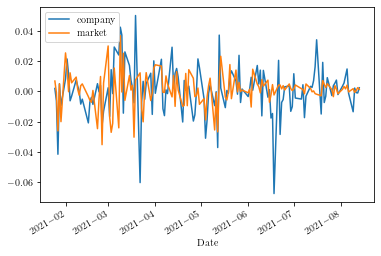

In [18]:
company_and_estimated = pd.DataFrame({"company":event_window_company_return, "market":estimated_return})
company_and_market = pd.DataFrame({"company": estimation_window_company_return, "market":estimation_window_market_return})
df_to_plot = pd.concat([company_and_market, company_and_estimated])
df_to_plot.plot()

DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.t

DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotli

DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is n

DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif

DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.t

DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\335aa01aa941a372c06f11f038134e80.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is 

DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is n

DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:ma

DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:latex -interaction=nonstopmode --halt-on-error ../c6f511b4968eb3689dd6467c5fcf7cb5.tex
DEBUG:matplotlib.texmanager:b'This is pdfTeX, Version 3.14159265-2.6-1.40.20 (MiKTeX 2.9.7250 64-bit)\r\nentering extended mode\r\n

DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\5cfb87afdf84f88755dee15eedbacd52.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chan

DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not c

DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chanc

DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif

DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is no

DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotli

DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is n

DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif

DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.t

DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is 

DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chanc

DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.t

DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is 

DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chanc

DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.t

DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\9ce57d3591ec712ad75287efaf3144e5.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is 

DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\b4f0081ba1faac12e03f07d59e0f570a.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chanc

DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '

DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\b4f0081ba1faac12e03f07d59e0f570a.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepa

DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotli

DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is n

DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible

DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\161d6dca5a8b151de70fc2276540ac8f.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chanc

DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:dvipng -bg Transparent -D 72.0 -T tight -o 'C:\Users\thoma\.matplotlib\tex.cache\4e654b2b99a1a74887598e53238187a8.png' 'C:\Users\thoma\.matplotlib\tex.cache\2c7ce4553bc980cb35a07a6adfc8db2f.dvi'
DEBUG:matplotlib.texmanager:b'This is dvipng 1.16 Copyright 2002-2015, 2019 Jan-Ake Larsson\r\n[1] \r\n'
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 54
DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 107 17
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 136 9
DEBUG:PIL.PngImage

DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is no

DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotli

DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is n

DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif

DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.t

DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is 

DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chanc

DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.t

DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is 

DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\3bbc0f8d536770a62891b7cc8788c317.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chanc

DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:ma

DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:dvipng -bg Transparent -D 72.0 -T tight -o 'C:\Users\thoma\.matplotlib\tex.cache\65880075a61bda435d47b1edeb5398e1.png' 'C:\Users\thoma\.matplotlib\tex.cache\5cfb87afdf84f88755dee15eedbacd52.dvi'
DEBUG:matplotlib.texmanager:b'This is dvipng 1.16 Copyright 2002-2015, 2019 Jan-Ake Larsson\r\n[1] \r\n'
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 54
DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 107 17
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 136 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 157 537
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font 

DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\141e69e681370afc2f1a554601f44c21.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chan

DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:ma

DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
DEBUG:matplotlib.dviread:Dvi: C:\Users\thoma\.matplotlib\tex.cache\18a250ee0223236c42c0afd70c02d79f.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:DejaVu Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not c

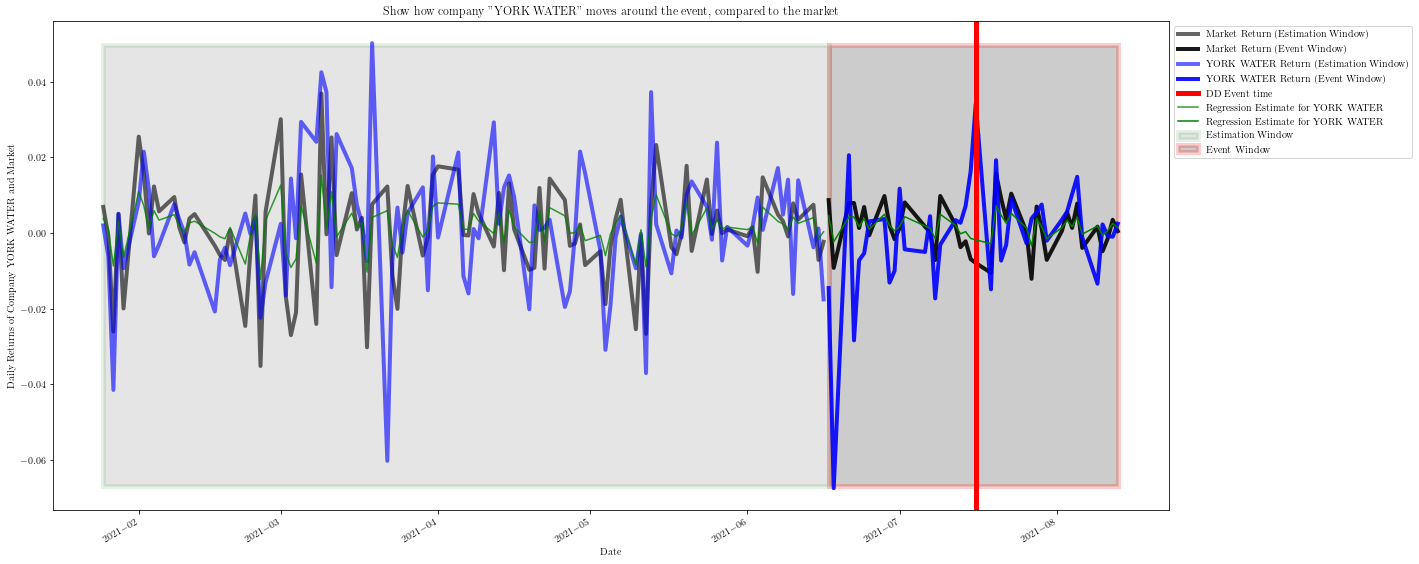

I'm impressed! It looks like a five-year-old drew this plot in paint


In [19]:
Company_name = company.name

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha

plt.figure(figsize=(20,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns of Company {Company_name} and Market')
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)

plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title(f'Show how company "{Company_name}" moves around the event, compared to the market')
plt.show()
print("I'm impressed! It looks like a five-year-old drew this plot in paint")


In [20]:
EVENT_INDEX = 20 # because right now 20 [0,..19] are before the event

## Macro Analysis

### Now that we have seen the process for one single filing, let us do the same for all filings in all companies


In [21]:
# Initialize testing
logging.getLogger().setLevel(logging.ERROR)

# Helpers
multiind, data, data_errors = [], [], []
n_companies = len(companies)

# this is the interval where filings are interesting to us
earliest_timestamp = pd.Timestamp("2018-01-01")
latest_timestamp = pd.Timestamp("2021-12-31")

for j in tqdm(range(len(companies[:200]))):
    # Get information from said company
    company = companies[j]
    company_return = company.return_index_df
    
    # Read in insider trading informations:
    filename = _insider_location + company.ticker + '.csv'
    filename = filename.replace(" ", "+") # HBB+WI in files and HBB WI as Ticker in base Excel, TODO should be fixed in base data
    insider_data_df = pd.read_csv(filename, index_col=0, parse_dates=['FilingDate', 'TradeDate'])
    
    
    n_filings = len(insider_data_df)
    # Go through all filings
    for i in insider_data_df.FilingDate.index:
        
        # Find our event date from filing
        filing_date = insider_data_df.FilingDate[i]
        event_timestamp = filing_date.floor("d")

        # if the timestamp is too early or too late we skip
        if event_timestamp < earliest_timestamp or event_timestamp > latest_timestamp:
            #print("skipping, filing is too early or too late")
            continue
            
        #print(f"working on company {j}/{n_companies} named {company.name}, filing {i}/{n_filings}")

        # do the process for one filing
        ## See if it's possible
        checks = data_checks.run(L1_length, L2_length, event_timestamp, company_return)
        if checks:
            #print(checks[1])
            data_errors.append(checks[0])
            continue
   
        ## Proceed to find periods
        T0_, T1_, T2_, T0, T1, T2, ERRORS, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)
        if ERRORS:
            #print(msg)
            data_errors.append(ERRORS)
            continue
            
        ## Cut timeseries to the relevant periods, and split them
        windows = cut_timeseries.run(company_return, T0, T1, T2)
        estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows
        alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

        ## Calculate the abnormal returns
        abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
        
        ## Append to results set
        multiind.append((company.ticker, i, insider_data_df.TradeType[i], event_timestamp))
        data.append(abnormal_return)

100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


In [22]:
# process abnormal returns
df_abnormal_returns = pd.DataFrame.from_records([d.reset_index(drop=True) for d in data])
df_abnormal_returns.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])
df_abnormal_returns

0         1         2   \
Company i  TradeType    event_timestamp                                 
IMTE    0  S - Sale     2021-10-05       0.012126  0.021317  0.002348   
        1  S - Sale     2021-10-05       0.012126  0.021317  0.002348   
        2  A - Grant    2020-10-20       0.015693 -0.048428  0.044395   
        3  M - OptEx    2020-10-20       0.015693 -0.048428  0.044395   
ACGL    14 F - Tax      2021-11-18       0.002250  0.012087 -0.002870   
...                                           ...       ...       ...   
OTIVF   13 P - Purchase 2020-04-20      -0.109614  0.269924 -0.100871   
        14 P - Purchase 2020-01-02       0.108235 -0.112558 -0.022353   
        15 P - Purchase 2019-12-26       0.042746  0.004227 -0.077768   
        16 P - Purchase 2019-12-26       0.042746  0.004227 -0.077768   
        17 S - Sale     2018-11-23      -0.048000  0.047280  0.019877   

                                               3         4         5   \
Company i  TradeType    event_timestamp                                 
IMTE    0  S - Sale     2021-10-05       0.056889  0.020259 -0.106961   
        1  S - Sale     2021-10-05       0.056889  0.020259 -0.106961   
        2  A - Grant    2020-10-20      -0.025923 -0.037550 -0.035355   
        3  M - OptEx    2020-10-20      -0.025923 -0.037550 -0.035355   
ACGL    14 F - Tax      2021-11-18      -0.004898 -0.019147 -0.015832   
...                                           ...       ...       ...   
OTIVF   13 P - Purchase 2020-04-20      -0.091827  0.004483  0.041696   
        14 P - Purchase 2020-01-02       0.004554 -0.051145  0.005242   
        15 P - Purchase 2019-12-26      -0.089227  0.106677 -0.113205   
        16 P - Purchase 2019-12-26      -0.089227  0.106677 -0.113205   
        17 S - Sale     2018-11-23      -0.009062 -0.040512 -0.018759   

                                               6         7         8   \
Company i  TradeType    event_timestamp                                 
IMTE    0  S - Sale     2021-10-05      -0.014988 -0.011138  0.029817   
        1  S - Sale     2021-10-05      -0.014988 -0.011138  0.029817   
        2  A - Grant    2020-10-20       0.030909 -0.027829  0.031959   
        3  M - OptEx    2020-10-20       0.030909 -0.027829  0.031959   
ACGL    14 F - Tax      2021-11-18      -0.007438  0.013804  0.011532   
...                                           ...       ...       ...   
OTIVF   13 P - Purchase 2020-04-20      -0.095036  0.140805  0.049168   
        14 P - Purchase 2020-01-02       0.004916  0.004728 -0.109930   
        15 P - Purchase 2019-12-26      -0.023412  0.004291 -0.052577   
        16 P - Purchase 2019-12-26      -0.023412  0.004291 -0.052577   
        17 S - Sale     2018-11-23      -0.007790  0.050263  0.020783   

                                               9   ...        31        32  \
Company i  TradeType    event_timestamp            ...                       
IMTE    0  S - Sale     2021-10-05       0.039381  ...  0.005358 -0.006296   
        1  S - Sale     2021-10-05       0.039381  ...  0.005358 -0.006296   
        2  A - Grant    2020-10-20      -0.010526  ... -0.017747  0.077877   
        3  M - OptEx    2020-10-20      -0.010526  ... -0.017747  0.077877   
ACGL    14 F - Tax      2021-11-18      -0.004619  ...  0.015053 -0.014297   
...                                           ...  ...       ...       ...   
OTIVF   13 P - Purchase 2020-04-20      -0.165943  ...  0.044070  0.323553   
        14 P - Purchase 2020-01-02      -0.001036  ...  0.001713 -0.030741   
        15 P - Purchase 2019-12-26       0.004090  ...  0.008916 -0.076403   
        16 P - Purchase 2019-12-26       0.004090  ...  0.008916 -0.076403   
        17 S - Sale     2018-11-23      -0.031316  ...  0.003178  0.000647   

                                               33        34        35  \
Company i  TradeType    event_timestamp                                 
IMTE    0  S - Sale     2021-10-05  

### Show the reasons filings were dropped

<AxesSubplot:>

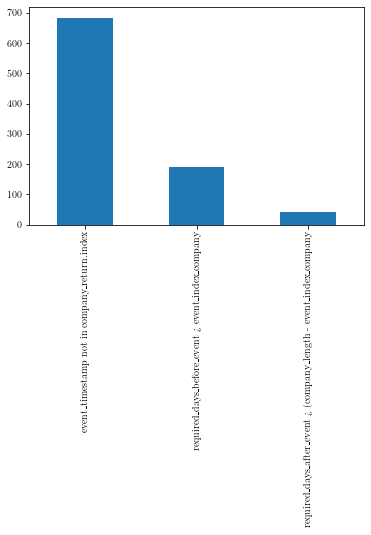

In [23]:
errors_df = pd.DataFrame.from_records(data_errors)
errors_df.sum(axis=0).plot.bar()

### Having a look at all trade types together

In [24]:
df_abnormal_returns.loc[:,:,["P - Purchase", "S - Sale", "S - Sale+OE"],:]

0         1         2   \
Company i   TradeType    event_timestamp                                 
ACGL    23  P - Purchase 2021-11-12      -0.011237 -0.008574 -0.011561   
        78  P - Purchase 2020-05-20      -0.046837 -0.021745 -0.042353   
        81  P - Purchase 2020-05-15       0.011601  0.000333 -0.005330   
        94  P - Purchase 2020-05-08       0.073148 -0.060993 -0.046641   
        179 P - Purchase 2018-11-29       0.017040  0.003109 -0.018433   
...                                            ...       ...       ...   
HZNP    430 S - Sale+OE  2019-08-23       0.012239  0.019014  0.011145   
        439 S - Sale+OE  2019-08-05      -0.049494  0.009681 -0.000344   
        538 S - Sale+OE  2018-11-16       0.002021  0.004709 -0.052683   
        559 S - Sale+OE  2018-06-05       0.015425  0.005416 -0.065510   
        561 S - Sale+OE  2018-05-30       0.061403  0.002247 -0.015074   

                                                3         4         5   \
Company i   TradeType    event_timestamp                                 
ACGL    23  P - Purchase 2021-11-12       0.013640  0.001997  0.012204   
        78  P - Purchase 2020-05-20       0.032686  0.025542 -0.007387   
        81  P - Purchase 2020-05-15      -0.046623 -0.021645 -0.042186   
        94  P - Purchase 2020-05-08      -0.044189 -0.050032  0.009853   
        179 P - Purchase 2018-11-29      -0.005547 -0.001299 -0.002184   
...                                            ...       ...       ...   
HZNP    430 S - Sale+OE  2019-08-23       0.015164  0.013502  0.002484   
        439 S - Sale+OE  2019-08-05       0.004989 -0.010139  0.000874   
        538 S - Sale+OE  2018-11-16       0.009169 -0.066469  0.056604   
        559 S - Sale+OE  2018-06-05      -0.014083  0.039092  0.050945   
        561 S - Sale+OE  2018-05-30       0.010782  0.015823  0.005463   

                                                6         7         8   \
Company i   TradeType    event_timestamp                                 
ACGL    23  P - Purchase 2021-11-12      -0.003195 -0.005008 -0.019241   
        78  P - Purchase 2020-05-20      -0.053184  0.005794  0.018287   
        81  P - Purchase 2020-05-15       0.032831  0.025586 -0.007143   
        94  P - Purchase 2020-05-08      -0.000962 -0.006165 -0.048641   
        179 P - Purchase 2018-11-29       0.008996  0.007363  0.000558   
...                                            ...       ...       ...   
HZNP    430 S - Sale+OE  2019-08-23      -0.023978  0.010981  0.118475   
        439 S - Sale+OE  2019-08-05       0.016742  0.022201  0.011517   
        538 S - Sale+OE  2018-11-16       0.035678  0.009273 -0.034597   
        559 S - Sale+OE  2018-06-05       0.002459  0.000427  0.009747   
        561 S - Sale+OE  2018-05-30      -0.065003 -0.013631  0.039114   

                                                9   ...        31        32  \
Company i   TradeType    event_timestamp            ...                       
ACGL    23  P - Purchase 2021-11-12      -0.016283  ... -0.022326  0.020497   
        78  P - Purchase 2020-05-20      -0.012839  ...  0.044768  0.008856   
        81  P - Purchase 2020-05-15      -0.053095  ...  0.040572  0.059108   
        94  P - Purchase 2020-05-08      -0.023132  ...  0.038687  0.010874   
        179 P - Purchase 2018-11-29       0.004839  ... -0.006537  0.012192   
...                                            ...  ...       ...       ...   
HZNP    430 S - Sale+OE  2019-08-23       0.020858  ...  0.001168 -0.000657   
        439 S - Sale+OE  2019-08-05      -0.015873  ...  0.008395  0.006173   
        538 S - Sale+OE  2018-11-16       0.046764  ...  0.014763 -0.015048   
        559 S - Sale+OE  2018-06-05       0.007477  ...  0.004743 -0.000671   
        561 S - Sale+OE  2018-05-30       0.051034  ...  0.008621 -0.005695   

                                                33        34        35  \
Company i   TradeType    event_timestamp                 

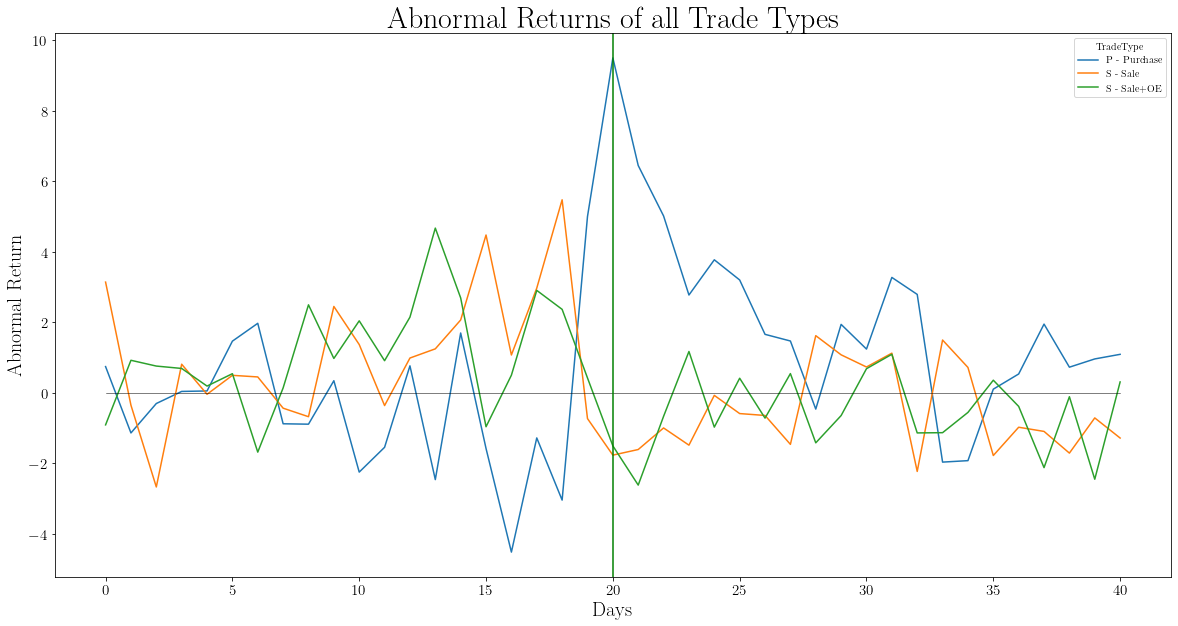

In [25]:

a = df_abnormal_returns.loc[:,:,["P - Purchase", "S - Sale", "S - Sale+OE"],:].groupby(level=[2]).sum().transpose().plot(figsize=(20, 10), fontsize=15)
plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
a.set_title("Abnormal Returns of all Trade Types",fontsize=30)
a.set_xlabel("Days", fontsize=20)
a.set_ylabel("Abnormal Return", fontsize=20)
plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes.png", dpi=600)

In [26]:
df_abnormal_returns

0         1         2   \
Company i  TradeType    event_timestamp                                 
IMTE    0  S - Sale     2021-10-05       0.012126  0.021317  0.002348   
        1  S - Sale     2021-10-05       0.012126  0.021317  0.002348   
        2  A - Grant    2020-10-20       0.015693 -0.048428  0.044395   
        3  M - OptEx    2020-10-20       0.015693 -0.048428  0.044395   
ACGL    14 F - Tax      2021-11-18       0.002250  0.012087 -0.002870   
...                                           ...       ...       ...   
OTIVF   13 P - Purchase 2020-04-20      -0.109614  0.269924 -0.100871   
        14 P - Purchase 2020-01-02       0.108235 -0.112558 -0.022353   
        15 P - Purchase 2019-12-26       0.042746  0.004227 -0.077768   
        16 P - Purchase 2019-12-26       0.042746  0.004227 -0.077768   
        17 S - Sale     2018-11-23      -0.048000  0.047280  0.019877   

                                               3         4         5   \
Company i  TradeType    event_timestamp                                 
IMTE    0  S - Sale     2021-10-05       0.056889  0.020259 -0.106961   
        1  S - Sale     2021-10-05       0.056889  0.020259 -0.106961   
        2  A - Grant    2020-10-20      -0.025923 -0.037550 -0.035355   
        3  M - OptEx    2020-10-20      -0.025923 -0.037550 -0.035355   
ACGL    14 F - Tax      2021-11-18      -0.004898 -0.019147 -0.015832   
...                                           ...       ...       ...   
OTIVF   13 P - Purchase 2020-04-20      -0.091827  0.004483  0.041696   
        14 P - Purchase 2020-01-02       0.004554 -0.051145  0.005242   
        15 P - Purchase 2019-12-26      -0.089227  0.106677 -0.113205   
        16 P - Purchase 2019-12-26      -0.089227  0.106677 -0.113205   
        17 S - Sale     2018-11-23      -0.009062 -0.040512 -0.018759   

                                               6         7         8   \
Company i  TradeType    event_timestamp                                 
IMTE    0  S - Sale     2021-10-05      -0.014988 -0.011138  0.029817   
        1  S - Sale     2021-10-05      -0.014988 -0.011138  0.029817   
        2  A - Grant    2020-10-20       0.030909 -0.027829  0.031959   
        3  M - OptEx    2020-10-20       0.030909 -0.027829  0.031959   
ACGL    14 F - Tax      2021-11-18      -0.007438  0.013804  0.011532   
...                                           ...       ...       ...   
OTIVF   13 P - Purchase 2020-04-20      -0.095036  0.140805  0.049168   
        14 P - Purchase 2020-01-02       0.004916  0.004728 -0.109930   
        15 P - Purchase 2019-12-26      -0.023412  0.004291 -0.052577   
        16 P - Purchase 2019-12-26      -0.023412  0.004291 -0.052577   
        17 S - Sale     2018-11-23      -0.007790  0.050263  0.020783   

                                               9   ...        31        32  \
Company i  TradeType    event_timestamp            ...                       
IMTE    0  S - Sale     2021-10-05       0.039381  ...  0.005358 -0.006296   
        1  S - Sale     2021-10-05       0.039381  ...  0.005358 -0.006296   
        2  A - Grant    2020-10-20      -0.010526  ... -0.017747  0.077877   
        3  M - OptEx    2020-10-20      -0.010526  ... -0.017747  0.077877   
ACGL    14 F - Tax      2021-11-18      -0.004619  ...  0.015053 -0.014297   
...                                           ...  ...       ...       ...   
OTIVF   13 P - Purchase 2020-04-20      -0.165943  ...  0.044070  0.323553   
        14 P - Purchase 2020-01-02      -0.001036  ...  0.001713 -0.030741   
        15 P - Purchase 2019-12-26       0.004090  ...  0.008916 -0.076403   
        16 P - Purchase 2019-12-26       0.004090  ...  0.008916 -0.076403   
        17 S - Sale     2018-11-23      -0.031316  ...  0.003178  0.000647   

                                               33        34        35  \
Company i  TradeType    event_timestamp                                 
IMTE    0  S - Sale     2021-10-05  

I think OE and OptEx means option exercise. "to exercise" means to put into effect the right to buy or sell the underlying security that is specified in the options contract." Can we be sure that the action does not shift the market, and the swing in return is really due to new information? Are these trades public, so maybe they are used as a signal for traders?

### Boxplot of the sum over all companies's AR

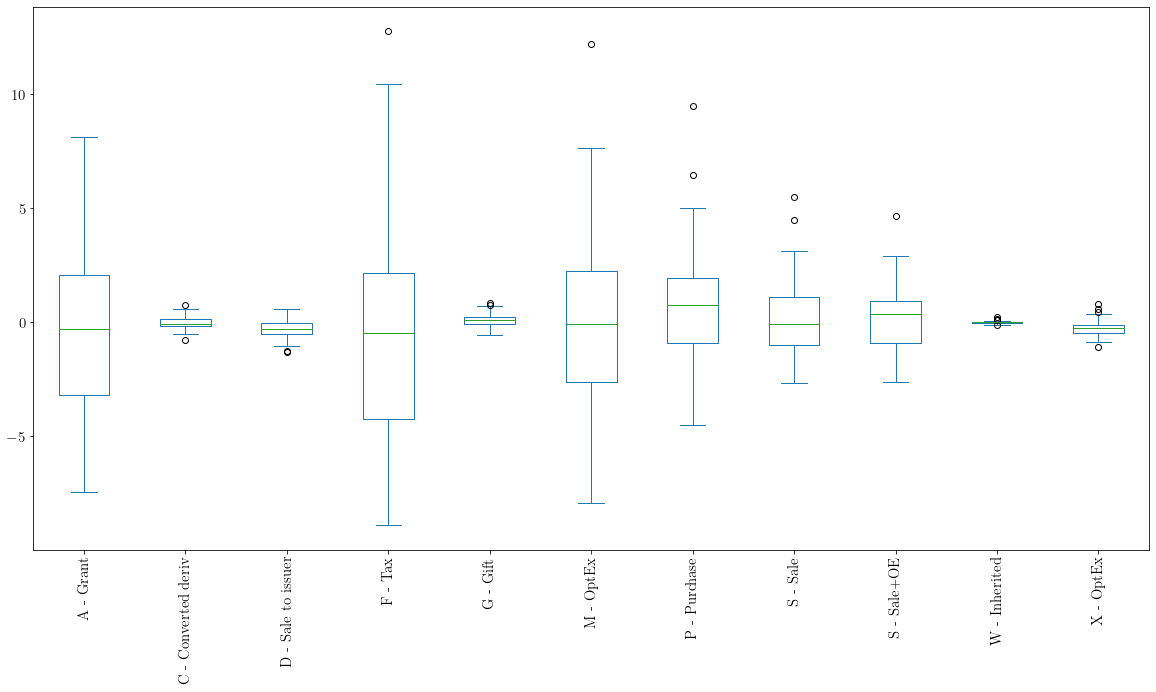

In [27]:
df_abnormal_returns.groupby(level=[2]).sum().transpose().plot.box(rot=90, figsize=(20, 10), fontsize=15)
ax.set_title("Boxplots of the Abnormal Returns for each Trade Type",fontsize=30)
ax.set_xlabel("Trade Type", fontsize=20)
ax.set_ylabel("Abnormal Return", fontsize=20)

plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes_boxplot.png", dpi=600)

![alt text](assets/images/time_agg.png)

In our case it is not company i, but filing i

Types of trade to pick from:

In [28]:
types = list(set([x[2] for x in df_abnormal_returns.index]))
types

['D - Sale to issuer',
 'C - Converted deriv',
 'M - OptEx',
 'A - Grant',
 'S - Sale+OE',
 'W - Inherited',
 'G - Gift',
 'P - Purchase',
 'S - Sale',
 'X - OptEx',
 'F - Tax']

Specify the type of the trades to investigate

In [29]:
type_ = "P - Purchase" # "S - Sale"
df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]

The index describes the company and the index of the filing in the compnay, the columns represent the days in the event window

In [30]:
df_abnormal_returns_type

0         1         2         3         4   \
Company i   event_timestamp                                                     
ACGL    23  2021-11-12      -0.011237 -0.008574 -0.011561  0.013640  0.001997   
        78  2020-05-20      -0.046837 -0.021745 -0.042353  0.032686  0.025542   
        81  2020-05-15       0.011601  0.000333 -0.005330 -0.046623 -0.021645   
        94  2020-05-08       0.073148 -0.060993 -0.046641 -0.044189 -0.050032   
        179 2018-11-29       0.017040  0.003109 -0.018433 -0.005547 -0.001299   
...                               ...       ...       ...       ...       ...   
OTIVF   12  2020-04-20      -0.109614  0.269924 -0.100871 -0.091827  0.004483   
        13  2020-04-20      -0.109614  0.269924 -0.100871 -0.091827  0.004483   
        14  2020-01-02       0.108235 -0.112558 -0.022353  0.004554 -0.051145   
        15  2019-12-26       0.042746  0.004227 -0.077768 -0.089227  0.106677   
        16  2019-12-26       0.042746  0.004227 -0.077768 -0.089227  0.106677   

                                   5         6         7         8         9   \
Company i   event_timestamp                                                     
ACGL    23  2021-11-12       0.012204 -0.003195 -0.005008 -0.019241 -0.016283   
        78  2020-05-20      -0.007387 -0.053184  0.005794  0.018287 -0.012839   
        81  2020-05-15      -0.042186  0.032831  0.025586 -0.007143 -0.053095   
        94  2020-05-08       0.009853 -0.000962 -0.006165 -0.048641 -0.023132   
        179 2018-11-29      -0.002184  0.008996  0.007363  0.000558  0.004839   
...                               ...       ...       ...       ...       ...   
OTIVF   12  2020-04-20       0.041696 -0.095036  0.140805  0.049168 -0.165943   
        13  2020-04-20       0.041696 -0.095036  0.140805  0.049168 -0.165943   
        14  2020-01-02       0.005242  0.004916  0.004728 -0.109930 -0.001036   
        15  2019-12-26      -0.113205 -0.023412  0.004291 -0.052577  0.004090   
        16  2019-12-26      -0.113205 -0.023412  0.004291 -0.052577  0.004090   

                             ...        31        32        33        34  \
Company i   event_timestamp  ...                                           
ACGL    23  2021-11-12       ... -0.022326  0.020497  0.032558  0.011523   
        78  2020-05-20       ...  0.044768  0.008856 -0.035420 -0.048748   
        81  2020-05-15       ...  0.040572  0.059108  0.026241  0.044951   
        94  2020-05-08       ...  0.038687  0.010874 -0.021076 -0.042151   
        179 2018-11-29       ... -0.006537  0.012192 -0.004442 -0.012006   
...                          ...       ...       ...       ...       ...   
OTIVF   12  2020-04-20       ...  0.044070  0.323553 -0.022971 -0.116492   
        13  2020-04-20       ...  0.044070  0.323553 -0.022971 -0.116492   
        14  2020-01-02       ...  0.001713 -0.030741  0.107152 -0.013447   
        15  2019-12-26       ...  0.008916 -0.076403 -0.115883 -0.126379   
        16  2019-12-26       ...  0.008916 -0.076403 -0.115883 -0.126379   

                                   35        36        37        38        39  \
Company i   event_timestamp                                                     
ACGL    23  2021-11-12       0.014721 -0.015167 -0.003748  0.012887 -0.005969   
        78  2020-05-20      -0.007916  0.001389 -0.003642 -0.008689 -0.014328   
        81  2020-05-15       0.009002 -0.035307 -0.048621 -0.008027  0.001530   
        94  2020-05-08       0.025338  0.038972  0.057473  0.024883  0.043074   
        179 2018-11-29       0.000009 -0.019412  0.018335  0.022009 -0.006167   
...                               ...       ...       ...       ...       ...   
OTIVF   12  2020-04-20       0.128007  0.009439  0.012552 -0.040514 -0.064082   
        13  2020-04-20       0.128007  0.009439  0.012552 -0.040514 -0.064082   
        14  2020-01-02       0.040392 -0.027018 -0.033456  0.044378 -0.067292   
        15  2019-12-26       0.000898 -0.032000

In [31]:
# TODO Infinity Values idk why, should check out why they are there upstream

In [32]:
mask = (-df_abnormal_returns_type == np.Inf) |(df_abnormal_returns_type == np.Inf)
df_abnormal_returns_type[mask] = 0

C:\Users\thoma\AppData\Local\Temp\ipykernel_12968\711303784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abnormal_returns_type[mask] = 0
C:\Users\thoma\AppData\Local\Temp\ipykernel_12968\711303784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abnormal_returns_type[mask] = 0


In [33]:
mask.sum().sum()

0

<AxesSubplot:xlabel='Company,i,event_timestamp'>

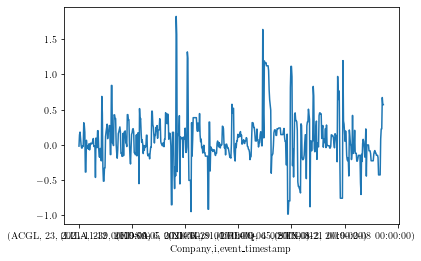

In [34]:
CAR = df_abnormal_returns_type.sum(axis=1)
CAR.plot()

![alt text](assets/images/cross_sectional_agg.png)


<AxesSubplot:>

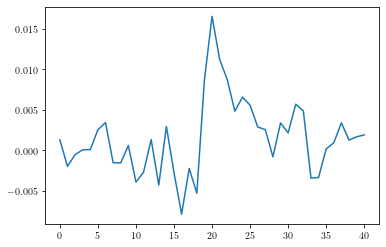

In [35]:
AR_bar = df_abnormal_returns_type.mean(axis=0) 
AR_bar.plot()

In [36]:
CAR_bar = AR_bar.sum()
CAR_bar

0.06329067576688777

In [37]:
# TODO var_CAR_bar = Does the definition make sense? It seems like we take the var of a scalar

![alt text](assets/images/cross_sectional_agg2.png)


In [38]:
CAR_bar_2 = CAR.mean()
CAR_bar_2

0.06329067576688775

In [39]:
# var car TODO not sure what just sigma means.

## Statistics

Check if CAR mean = 0 (t-test)

In [40]:
from scipy import stats

tt = stats.ttest_1samp(CAR, popmean=0)
tt

Ttest_1sampResult(statistic=4.236230291182802, pvalue=2.6481964320053476e-05)

Check if CAR median = 0 (wilcoxon signed rank test)

In [41]:
stats.wilcoxon(CAR)

WilcoxonResult(statistic=64749.0, pvalue=7.868280937947564e-06)

In [42]:
types = types
investigation_periods = {
    "overall": (pd.Timestamp("2018-01-01"), pd.Timestamp("2021-12-31")),
    "pre-pandemic": (pd.Timestamp("2018-01-01"), pd.Timestamp("2020-02-29")),
    "pandemic": (pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31")),
}

multiind_p, data_p = [], []

event_day_ranges = {
    "before": (0,20), # TODO for now we drop the filing day itself
    "after": (21,41)
}


for type_ in types:
    for per in investigation_periods.keys():
        for side in event_day_ranges.keys():
                
            event_day_range = event_day_ranges[side]
            df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]
            per_left,per_right = investigation_periods[per]


            timestamps = df_abnormal_returns_type.index.get_level_values(2)
            mask = (timestamps >= per_left) & (timestamps <= per_right)
            df_AR_type_per = df_abnormal_returns_type[mask]
            if not len(df_AR_type_per):
                print(f"skipping iteration because of 0 datapoints {(type_, per, side)}")
                continue
            df_AR_type_per_side = df_AR_type_per.iloc[:,event_day_range[0]:event_day_range[1]]
            CAR = df_AR_type_per_side.sum(axis=1)

            pvalue_ttest = round(stats.ttest_1samp(CAR, popmean=0).pvalue, 10)
            pvalue_wilcoxon = round(stats.wilcoxon(CAR).pvalue, 10)
            mean = CAR.mean()
            median = CAR.median()
            
            multiind_p.append((type_, per, side))
            data_p.append((mean, pvalue_ttest, median, pvalue_wilcoxon, len(df_AR_type_per)))

skipping iteration because of 0 datapoints ('C - Converted deriv', 'pre-pandemic', 'before')
skipping iteration because of 0 datapoints ('C - Converted deriv', 'pre-pandemic', 'after')


C:\Users\thoma\.conda\envs\IDP\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\.conda\envs\IDP\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\thoma\.conda\envs\IDP\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\.conda\envs\IDP\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
# process abnormal returns
df_p = pd.DataFrame.from_records(data_p)
df_p.index = pd.MultiIndex.from_tuples(multiind_p, names=["TradeType", "Period", "Side of the event"])
df_p.columns = ["mean", "ttest pvalue", "median", "wilcoxon pvalue", "sample_size"]
df_p.to_csv(f"data/{NAME}/tests_result.csv")
df_p.sort_values("ttest pvalue")

mean  ttest pvalue  \
TradeType     Period       Side of the event                           
P - Purchase  overall      after              0.060309  2.000000e-10   
              pre-pandemic after              0.065930  5.000000e-10   
S - Sale+OE   pandemic     after             -0.041226  2.887000e-07   
                           before             0.051259  1.966100e-06   
              overall      before             0.031970  2.829000e-06   
...                                                ...           ...   
A - Grant     pre-pandemic before             0.000361  9.144997e-01   
G - Gift      pre-pandemic after              0.000964  9.241353e-01   
P - Purchase  pre-pandemic before             0.000816  9.458734e-01   
W - Inherited pre-pandemic before            -0.019090           NaN   
                           after             -0.056591           NaN   

                                                median  wilcoxon pvalue  \
TradeType     Period       Side of the event                              
P - Purchase  overall      after              0.028384     1.400000e-09   
              pre-pandemic after              0.038004     2.400000e-09   
S - Sale+OE   pandemic     after             -0.017722     1.044890e-05   
                           before             0.035732     2.334600e-06   
              overall      before             0.015441     9.421200e-06   
...                                                ...              ...   
A - Grant     pre-pandemic before            -0.001445     6.455800e-01   
G - Gift      pre-pandemic after              0.001149     9.735989e-01   
P - Purchase  pre-pandemic before            -0.012839     3.434870e-01   
W - Inherited pre-pandemic before            -0.019090     1.000000e+00   
                           after             -0.056591     1.000000e+00   

                                              sample_size  
TradeType     Period       Side of the event               
P - Purchase  overall      after                      574  
              pre-pandemic after                      372  
S - Sale+OE   pandemic     after                      306  
                           before                     306  
              overall      before                     683  
...                                                   ...  
A - Grant     pre-pandemic before                    1034  
G - Gift      pre-pandemic after                      106  
P - Purchase  pre-pandemic before                     372  
W - Inherited pre-pandemic before                       1  
                           after                        1  

[64 rows x 5 columns]